**Import necessary libraries**

In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

**Prepare the Dataset**

In [4]:
df = pd.read_csv("278k_song_labelled.csv", index_col=0)
df = df.drop(['spec_rate','duration (ms)'], axis=1)

In [5]:
df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,labels
0,0.611,0.614,-8.815,0.0672,0.01690,0.000794,0.7530,0.520,128.050,2
1,0.638,0.781,-6.848,0.0285,0.01180,0.009530,0.3490,0.250,122.985,1
2,0.560,0.810,-8.029,0.0872,0.00710,0.000008,0.2410,0.247,170.044,1
3,0.525,0.699,-4.571,0.0353,0.01780,0.000088,0.0888,0.199,92.011,0
4,0.367,0.771,-5.863,0.1060,0.36500,0.000001,0.0965,0.163,115.917,1
...,...,...,...,...,...,...,...,...,...,...
277933,0.777,0.725,-9.012,0.0470,0.12600,0.010800,0.0917,0.851,128.349,1
277934,0.543,0.482,-12.789,0.1940,0.08530,0.000092,0.1110,0.415,193.513,1
277935,0.527,0.942,-5.640,0.0366,0.01150,0.000000,0.1880,0.495,148.723,2
277936,0.768,0.829,-5.109,0.0313,0.09640,0.000029,0.0970,0.962,118.773,1


In [6]:
# Select features and target
X = df.drop(['labels'], axis=1).values
y = df['labels'].values

# Normalize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

**Define a Model**

In [7]:
class shallow_nn(nn.Module):
    def __init__(self):
        super(shallow_nn, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)  # 4 classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = shallow_nn()

In [8]:
model

shallow_nn(
  (fc1): Linear(in_features=9, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

**Train and evaluate the model**

In [9]:
# Initialize lists to store accuracies
train_accuracies = []
test_accuracies = []

In [10]:
def train_and_evaluate(model, train_loader, test_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()  
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Evaluate on the test set
        model.eval()  
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

In [11]:
train_and_evaluate(model, train_loader, test_loader, epochs=10)

Epoch 1, Loss: 0.3391147141093821, Train Accuracy: 85.77%, Test Accuracy: 87.30%
Epoch 2, Loss: 0.29057344641112426, Train Accuracy: 87.56%, Test Accuracy: 87.94%
Epoch 3, Loss: 0.2770301362228601, Train Accuracy: 88.19%, Test Accuracy: 88.43%
Epoch 4, Loss: 0.26762624912994304, Train Accuracy: 88.59%, Test Accuracy: 88.33%
Epoch 5, Loss: 0.2614691973355481, Train Accuracy: 88.76%, Test Accuracy: 88.50%
Epoch 6, Loss: 0.2571556412406209, Train Accuracy: 89.00%, Test Accuracy: 88.56%
Epoch 7, Loss: 0.2529858180212793, Train Accuracy: 89.21%, Test Accuracy: 88.88%
Epoch 8, Loss: 0.25049705451236715, Train Accuracy: 89.29%, Test Accuracy: 89.17%
Epoch 9, Loss: 0.2476906191452036, Train Accuracy: 89.41%, Test Accuracy: 88.95%
Epoch 10, Loss: 0.2454340416144117, Train Accuracy: 89.48%, Test Accuracy: 89.43%


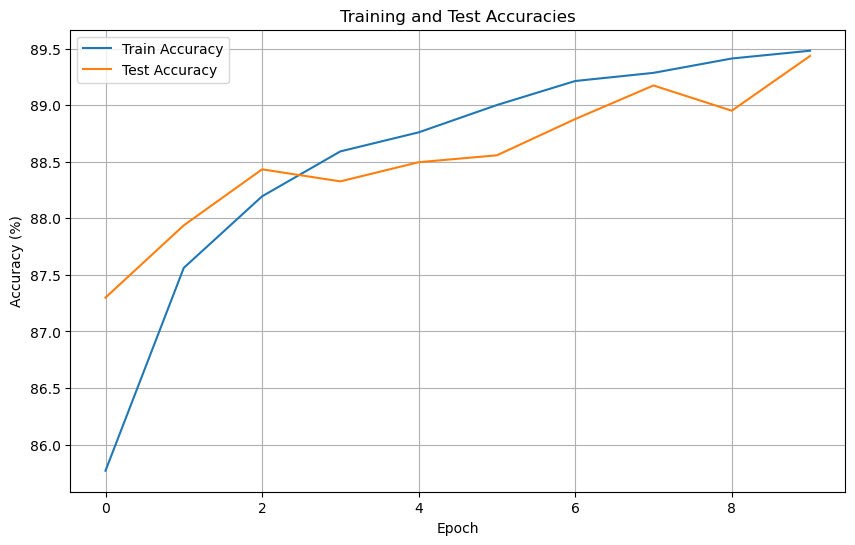

In [12]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracies')
plt.legend()
plt.grid(True)
plt.show()